Neural Nomads- Banana Assignment- Transfer Learning with BERT- Multiclass Sentiment Analysis Dataset


SURABHI M- PES1UG23AM325

GAHNAVI B- PES1UG23AM900

SMRITHI A S- PES1UG23AM306

In [1]:
!pip install -q transformers datasets scikit-learn matplotlib


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertModel
from datasets import load_dataset
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np


Exploratory Data Analysis (EDA):


Load dataset using Hugging Face datasets library

In [3]:
dataset = load_dataset("Sp1786/multiclass-sentiment-analysis-dataset")
dataset


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train_df.csv: 0.00B [00:00, ?B/s]

val_df.csv: 0.00B [00:00, ?B/s]

test_df.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/31232 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5205 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5206 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label', 'sentiment'],
        num_rows: 31232
    })
    validation: Dataset({
        features: ['id', 'text', 'label', 'sentiment'],
        num_rows: 5205
    })
    test: Dataset({
        features: ['id', 'text', 'label', 'sentiment'],
        num_rows: 5206
    })
})

Visualize class distribution of the training set

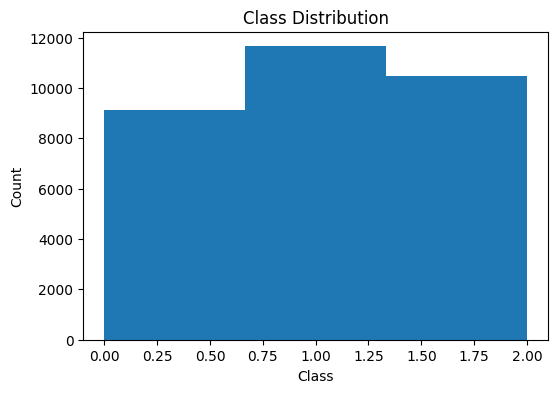

In [4]:
labels = dataset["train"]["label"]

plt.figure(figsize=(6,4))
plt.hist(labels, bins=len(set(labels)))
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


Briefly comment on class imbalance
The class distribution shows minor imbalance, but all sentiment classes are sufficiently represented, making the dataset suitable for supervised learning.

In [6]:
def tokenize(batch):
    texts = [str(t) if t is not None else "" for t in batch["text"]]
    return tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=128
    )


In [7]:
dataset = dataset.map(tokenize, batched=True)
dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])


Map:   0%|          | 0/31232 [00:00<?, ? examples/s]

Map:   0%|          | 0/5205 [00:00<?, ? examples/s]

Map:   0%|          | 0/5206 [00:00<?, ? examples/s]

In [8]:
train_loader = DataLoader(dataset["train"], batch_size=16, shuffle=True)
test_loader = DataLoader(dataset["test"], batch_size=16)


Model Fine-tuning (PyTorch ONLY)

Fine-tune the model on your chosen dataset.

In [9]:
class BertClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(768, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.pooler_output
        return self.fc(self.dropout(pooled))


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertClassifier(num_classes=len(set(labels))).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [12]:
EPOCHS = 2

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{EPOCHS}] - Loss: {avg_loss:.4f}")

print("✅ Training completed")


Epoch [1/2] - Loss: 0.3284
Epoch [2/2] - Loss: 0.2084
✅ Training completed


In [13]:
losses = []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()
        outputs = model(
            batch["input_ids"].to(device),
            batch["attention_mask"].to(device)
        )
        loss = criterion(outputs, batch["label"].to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    losses.append(total_loss / len(train_loader))


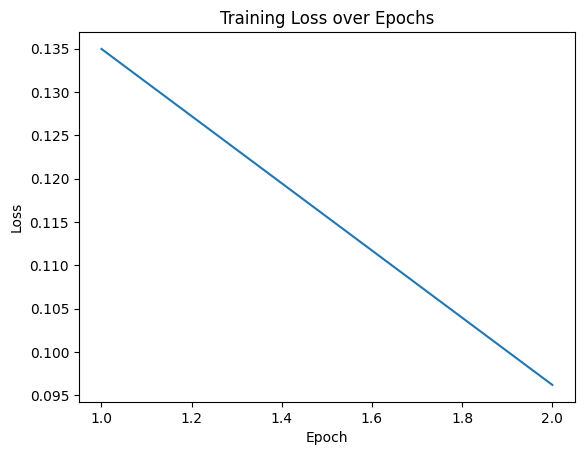

In [14]:
plt.plot(range(1, EPOCHS+1), losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.show()


Evaluation Metrics

Evaluate model on test set

In [15]:
model.eval()
preds, true = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask)
        predictions = torch.argmax(outputs, dim=1)

        preds.extend(predictions.cpu().numpy())
        true.extend(labels.cpu().numpy())


Report Accuracy, Precision, Recall, F1-Score (weighted)

In [16]:
acc = accuracy_score(true, preds)
prec, rec, f1, _ = precision_recall_fscore_support(true, preds, average="weighted")

print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1 Score:", f1)


Accuracy: 0.7514406454091433
Precision: 0.7550135933005147
Recall: 0.7514406454091433
F1 Score: 0.7524665807348706


Display a Confusion Matrix

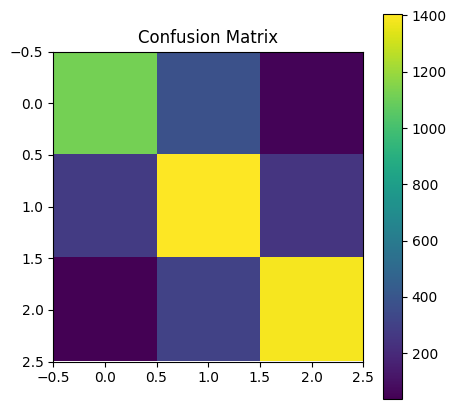

In [17]:
cm = confusion_matrix(true, preds)
plt.figure(figsize=(5,5))
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.colorbar()
plt.show()


Inference Pipeline

Create predict_text(text: str)
Test with 3–5 custom examples

In [21]:
def predict_text(text: str):
    model.eval()

    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=128
    )

    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        probs = torch.softmax(outputs, dim=1)

    confidence, predicted_class = torch.max(probs, dim=1)
    return predicted_class.item(), confidence.item()


In [22]:
examples = [
    "I love this product",
    "This is terrible",
    "It was okay, not great",
]

for e in examples:
    print(e, "->", predict_text(e))


I love this product -> (2, 0.9977477192878723)
This is terrible -> (0, 0.9990087747573853)
It was okay, not great -> (0, 0.9989945292472839)
